# Chatbot with Memory

In [2]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects in `store`, provide
- `namespace`: a tuple (similar to directory)
- `key`: similar to filename
- `value`: similar to file content

In [3]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id,'memories')

# Save a Memory to the namespace as key,value pair
key = str(uuid.uuid4()) # uuid4 -> random

# The value has to be a dictionary
value = {"animal_preference":"I like cats"}

# Save the memory 
in_memory_store.put(namespace_for_memory, key, value)

Using `search` to retrieve results as a list

In [3]:
memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='0293d219-d738-4480-afbf-4fccdca5ef08', value={'animal_preference': 'I like cats'}, created_at='2025-06-27T21:00:09.131605+00:00', updated_at='2025-06-27T21:00:09.131605+00:00', score=None)]

In [4]:
# metadata
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '0293d219-d738-4480-afbf-4fccdca5ef08',
 'value': {'animal_preference': 'I like cats'},
 'created_at': '2025-06-27T21:00:09.131605+00:00',
 'updated_at': '2025-06-27T21:00:09.131605+00:00',
 'score': None}

Using `get` to get the result - requires namespace and key

In [5]:
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '0293d219-d738-4480-afbf-4fccdca5ef08',
 'value': {'animal_preference': 'I like cats'},
 'created_at': '2025-06-27T21:00:09.131605+00:00',
 'updated_at': '2025-06-27T21:00:09.131605+00:00'}

## Chatbot with Memory
- Providing both short term and long term memory to chatbot - `Checkpointer` and `Store`
- thread_id and user_id - both are required

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

In [7]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot Instructions
MODEL_SYSTEM_MESSAGE = """ 
You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get user id
    user_id = config['configurable']['user_id']

    # Get the memory
    namespace = ('memory',user_id)
    key = "user_memory"
    existing_memory = store.get(namespace,key)

    # Extract the actual memory content if it exists
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    
    # Format the system prompt
    system_message = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # generate response from the llm
    return {'messages': model.invoke([SystemMessage(content=system_message)] + state['messages'])}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    "Reflect on the chat history and existing memory to write new memory to the store"

    # Get the user_id
    user_id = config['configurable']['user_id']

    # Get the memory
    namespace = ('memory', user_id)
    key = 'user_memory'
    existing_memory = store.get(namespace, key)

    # In case there is no memory# Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the prompt
    system_message = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_message)]+state['messages'])
    # Update the existing memory
    key = 'user_memory'

    # Write value as a dictionary
    value = {"memory":new_memory.content}

    # Put the new memory
    store.put(namespace,key,value)

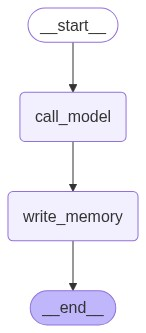

In [8]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Sample Run

In [9]:
# Thread_id and Config_id
config = {'configurable':{'thread_id':"thread_1", "user_id":"user_1"}}
# Input message
message = HumanMessage(content="Hey! My name is Manan.")

for event in graph.stream({'messages':[message]}, config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hey! My name is Manan.
================================== Ai Message ==================================

Hello, Manan! It's great to meet you. How can I assist you today?


In [10]:
# User input 
input_messages = [HumanMessage(content="I like to use Langgraph.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to use Langgraph.
================================== Ai Message ==================================

That's great to hear, Manan! Langgraph is a powerful tool for language analysis and visualization. What do you enjoy most about using it, or is there something specific you'd like to know or discuss about Langgraph?


### Checkpointer

In [19]:
thread = {"configurable": {"thread_id": "thread_1"}}
# get the state for the thread
state = graph.get_state(thread).values

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

Hey! My name is Manan.
================================== Ai Message ==================================

Hello, Manan! It's great to meet you. How can I assist you today?
================================ Human Message =================================

I like to use Langgraph.
================================== Ai Message ==================================

That's great to hear, Manan! Langgraph is a powerful tool for language analysis and visualization. What do you enjoy most about using it, or is there something specific you'd like to know or discuss about Langgraph?


### Store

In [21]:
user_id = 'user_1'
namespace = ('memory',user_id)
key = 'user_memory'

memory = across_thread_memory.get(namespace,key)
memory.dict()

{'namespace': ['memory', 'user_1'],
 'key': 'user_memory',
 'value': {'memory': "**Updated User Information:**\n- User's name is Manan.\n- Likes to use Langgraph."},
 'created_at': '2025-06-27T21:00:49.915718+00:00',
 'updated_at': '2025-06-27T21:00:49.915718+00:00'}